# **Introduction**
Mosquito-borne diseases, such as malaria, dengue, and Zika, pose significant public health threats globally, affecting millions of individuals annually—especially in tropical regions. Effective mosquito species identification is crucial for implementing timely vector control measures and preventing outbreaks. Traditionally, species identification relies on human expertise in entomology, which is both time-consuming and prone to human error.

Recent advances in computer vision and deep learning have revolutionized image recognition, offering automated and highly accurate solutions for tasks such as species classification. Leveraging these technologies, researchers are developing machine learning frameworks to classify mosquitoes from images—particularly those captured on human skin—for real-time vector identification and control.

In this project, a **Residual Network layer 50 (resnnet-50)** model is developed to classify six different mosquito classes with the goal of supporting accurate and efficient species identification for improved disease prevention.

**The code implementation consists of 6 steps:**


1.   Initial Setup
2.   Exploratory Analysis of Data
3.   Model Design
4.   Training, Validating and Tesing
5.   Results visualization
6.   Discussion

# **Motivation**
Accurately identifying mosquito species is challenging because of subtle visual differences, which can be difficult for humans to distinguish. Traditional methods like measuring wing-flapping frequency are limited and not scalable. As image classification continues to improve through deep learning, there is growing potential to develop automated systems that assist in mosquito species recognition, ultimately contributing to better disease prevention.

# **Problem Statement**
Mosquitoes pose substantial threat to public health resulting in million number of deaths worldwide every year. They act as the vectors responsible for diseases. The
harmful mosquito species are contained in the genera Aedes, Anopheles and Culex. Since the differences between
species are trivial for human vision, the current prevailing approach for identifying mosquito's species is based on
recording the frequency of wing flapping, image classification of mosquitos is still a developing problem that requiring
contributions.

# **Data Source**
The dataset used in this project consists of **RGB images of mosquitoes**, specifically collected for training and evaluating recognition systems that identify mosquitoes on human skin. The images were sourced from a **WHO-accredited breeding laboratory** in 2022, ensuring accurate species labeling and reliable annotations. The dataset includes **three mosquito species** which are ***Aedes aegypti, Aedes albopictus, and Culex quinquefasciatus*** and each captured in two physical conditions: ***normal landing and smashed***. This results in a total of six well-defined classes, making the dataset highly suitable for supervised learning tasks.

# **Code Implementation**
## **STEP1: Initial Setup**

In [1]:
import torch
if torch.cuda.is_available():
    print("GPU is available!")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available, using CPU.")

GPU is available!
GPU name: NVIDIA GeForce RTX 3060 Ti


In [2]:
# Create a list of all the class names
import os
IMAGE_DIR = "data\\Mosquito-on-human-skin\\data_splitting"
class_names = sorted(os.listdir(IMAGE_DIR+"/Pred"))
class_names

['Culex landing',
 'Culex smashed',
 'aegypti landing',
 'aegypti smashed',
 'albopictus landing',
 'albopictus smashed']

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils
from torch.utils.data import random_split
import torch.utils.data
from collections import defaultdict
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## **STEP2: Exploratory Analysis of Data**
## Class Transform - Preporcessing
This section handles the data preprocessing pipeline for training ResNet-50 on the mosquito classification dataset. The preprocessing includes:

**Training Data Augmentation:**
- **Resize**: Images resized to 224×224 pixels (required input size for ResNet-50)
- **Random Flips**: Horizontal and vertical flips (50% probability each) to increase data diversity
- **Random Rotation**: Up to 15 degrees rotation to simulate different viewing angles
- **Color Jitter**: Adjusts brightness, contrast, saturation, and hue to improve robustness
- **Normalization**: Uses ImageNet statistics (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) for transfer learning compatibility

**Test Data Processing:**
- Only applies resize and normalization (no augmentation to ensure consistent evaluation)

**Dataset Split:**
- Training data is further split into 80% training and 20% validation
- Batch size of 32 with data loading optimization (num_workers=2, pin_memory=True)

In [4]:
# Data preprocessing for ResNet-50 (requires 224x224 input)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# Create datasets and data loaders
trainset = datasets.ImageFolder(root="data/Mosquito-on-human-skin/data_splitting/Train", transform=transform_train)

# Split training set into train and validation
train_size = int(len(trainset) * 0.8)
val_size = len(trainset) - train_size
train_subset, val_subset = random_split(trainset, [train_size, val_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Test dataset
testset = datasets.ImageFolder(root="data/Mosquito-on-human-skin/data_splitting/Test", transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(testset)}")
print(f"Number of classes: {len(class_names)}")

Training samples: 3360
Validation samples: 840
Test samples: 1799
Number of classes: 6


### **From the above output we can observe:**
The dataset is divided into **training, testing, and prediction** subsets, each containing RGB images labeled into **six distinct classes**. These classes are based on combinations of three mosquito species (Aedes aegypti, Aedes albopictus, and Culex quinquefasciatus) and two physical conditions (landing and smashed):


*   Culex landing
*   Culex smashed
*   Aedes aegypti landing
*   Aedes aegypti smashed
*   Aedes albopictus landing
*   Aedes albopictus smashed

Each image is in RGB format, with a standardized resolution of 64x64 pixels.


All subsets are **evenly distributed** across the six classes, ensuring balanced training and fair evaluation. The only minor exception is Aedes albopictus landing in the test set, which has 299 samples.

However, challenges related to subtle visual differences and real-world image variation make this a non-trivial classification task.

## Display the sample of input images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179958].


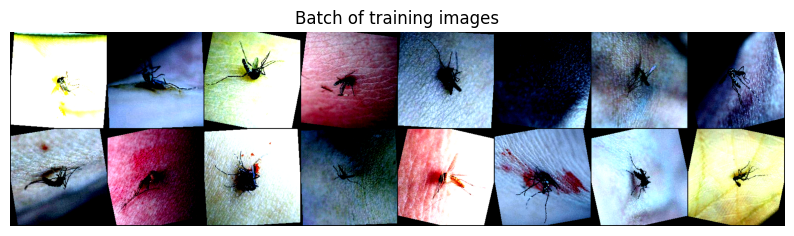

In [6]:
import matplotlib.pyplot as plt
import torchvision

# Get one batch
images, labels = next(iter(trainloader))

# Make a grid (8 images per row)
img_grid = torchvision.utils.make_grid(images[:16], nrow=8, padding=2)

# Convert from torch tensor to numpy and plot
plt.figure(figsize=(10, 5))
plt.imshow(img_grid.permute(1, 2, 0))  # Change from [C,H,W] to [H,W,C]
plt.axis('off')
plt.title("Batch of training images")
plt.show()

## **STEP3: Model Design**

ResNet-50 is a 50-layer deep convolutional neural network that revolutionized deep learning by introducing **residual connections** (skip connections). This architecture solves the vanishing gradient problem that prevents training of very deep networks.

**Key Components:**

**Bottleneck Block:**
- Uses 1×1 → 3×3 → 1×1 convolution pattern
- **Expansion factor of 4**: Output channels = 4 × input channels
- **Skip connections**: Adds input directly to output (F(x) + x)
- Enables gradient flow through the network during backpropagation

**ResNet-50 Architecture:**
- **Initial Layer**: 7×7 conv + max pooling
- **Layer1**: 3 Bottleneck blocks (64 → 256 channels)
- **Layer2**: 4 Bottleneck blocks (256 → 512 channels)  
- **Layer3**: 6 Bottleneck blocks (512 → 1024 channels)
- **Layer4**: 3 Bottleneck blocks (1024 → 2048 channels)
- **Final**: Global average pooling + fully connected layer

**Benefits:**
- Enables training of very deep networks (50+ layers)
- Better feature learning through residual connections
- Reduced overfitting with batch normalization and dropout

In [7]:
# ResNet-50 Implementation
class Bottleneck(nn.Module):
    expansion = 4
    
    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=6):
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.dropout = nn.Dropout(p=0.5)
    
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

def ResNet50(num_classes=6):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)

# Loss Function and Optimizer Working Logic

This section configures the training optimization strategy for effective learning of the ResNet-50 model.

**Loss Function - CrossEntropyLoss:**
- Suitable for multi-class classification (6 mosquito species)
- Combines softmax activation and negative log-likelihood loss
- Provides stable gradients and probability distributions over classes

**Optimizer - Adam:**
- **Learning Rate**: 0.001 (initial rate, will be adjusted by scheduler)
- **Weight Decay**: 1e-4 (L2 regularization to prevent overfitting)
- Adaptive learning rates for each parameter
- Combines benefits of momentum and RMSprop

**Learning Rate Scheduler - StepLR:**
- **Step Size**: 15 epochs (reduces learning rate every 15 epochs)
- **Gamma**: 0.1 (multiplies learning rate by 0.1)
- Schedule: 0.001 → 0.0001 → 0.00001 (at epochs 15, 30)
- Helps fine-tune the model in later epochs for better convergence

**Training Strategy:**
- **Early Stopping**: Saves best model based on validation accuracy
- **Progress Monitoring**: Tracks training/validation loss and accuracy
- **Gradient Management**: Zero gradients, backward pass, parameter updates

In [8]:
# Initialize device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create ResNet-50 model
model = ResNet50(num_classes=len(class_names)).to(device)

# Test the model
test_input = torch.randn(1, 3, 224, 224).to(device)
test_output = model(test_input)
print(f"Model output shape: {test_output.shape}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

Using device: cuda
Model output shape: torch.Size([1, 6])
Number of parameters: 23,520,326


### **evaluate() Function**
Evaluates the trained model on the test set:

Computes the number of correct predictions vs. total samples.

Returns overall test accuracy.


In [9]:
# Training and evaluation functions
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def train_model(model, trainloader, valloader, criterion, optimizer, scheduler, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if batch_idx % 20 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(trainloader)}, '
                      f'Loss: {loss.item():.4f}')
        
        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        
        # Validation phase
        val_loss, val_acc = evaluate(model, valloader, criterion, device)
        
        # Update learning rate
        scheduler.step()
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'  Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
        print('-' * 50)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_resnet50_mosquito.pth')
            print(f'New best model saved with validation accuracy: {val_acc:.2f}%')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [10]:
# Train the model
num_epochs = 30
print("Starting ResNet-50 training...")
print(f"Training for {num_epochs} epochs")
print(f"Class names: {class_names}")
print("=" * 60)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, trainloader, valloader, criterion, optimizer, scheduler, num_epochs, device
)

Starting ResNet-50 training...
Training for 30 epochs
Class names: ['Culex landing', 'Culex smashed', 'aegypti landing', 'aegypti smashed', 'albopictus landing', 'albopictus smashed']
Epoch 1/30, Batch 0/105, Loss: 2.2050
Epoch 1/30, Batch 20/105, Loss: 1.8719
Epoch 1/30, Batch 40/105, Loss: 1.7465
Epoch 1/30, Batch 60/105, Loss: 1.6792
Epoch 1/30, Batch 80/105, Loss: 1.9026
Epoch 1/30, Batch 100/105, Loss: 1.5315
Epoch 1/30:
  Train Loss: 1.8805, Train Acc: 26.43%
  Val Loss: 1.7464, Val Acc: 28.33%
  Learning Rate: 0.001000
--------------------------------------------------
New best model saved with validation accuracy: 28.33%
Epoch 2/30, Batch 0/105, Loss: 1.8263
Epoch 2/30, Batch 20/105, Loss: 1.9739
Epoch 2/30, Batch 40/105, Loss: 1.3746
Epoch 2/30, Batch 60/105, Loss: 1.8664
Epoch 2/30, Batch 80/105, Loss: 1.6374
Epoch 2/30, Batch 100/105, Loss: 1.5144
Epoch 2/30:
  Train Loss: 1.6412, Train Acc: 33.36%
  Val Loss: 2.6958, Val Acc: 33.81%
  Learning Rate: 0.001000
---------------

## **STEP5: Results visualization**

The two visualization approaches - Confusion matrix and line chart, clearly show that the culex landing and culex smashed classes can be classified very accurately using this ResNet-50 model, with accuracy reaching 100%. However, the albopictus smashed class demonstrates lower performance, as it is sometimes confused with the aegypti smashed class, resulting in a classification accuracy of only 80%. The rest three classes also have decent performance which contains accuacy around 89.22%.

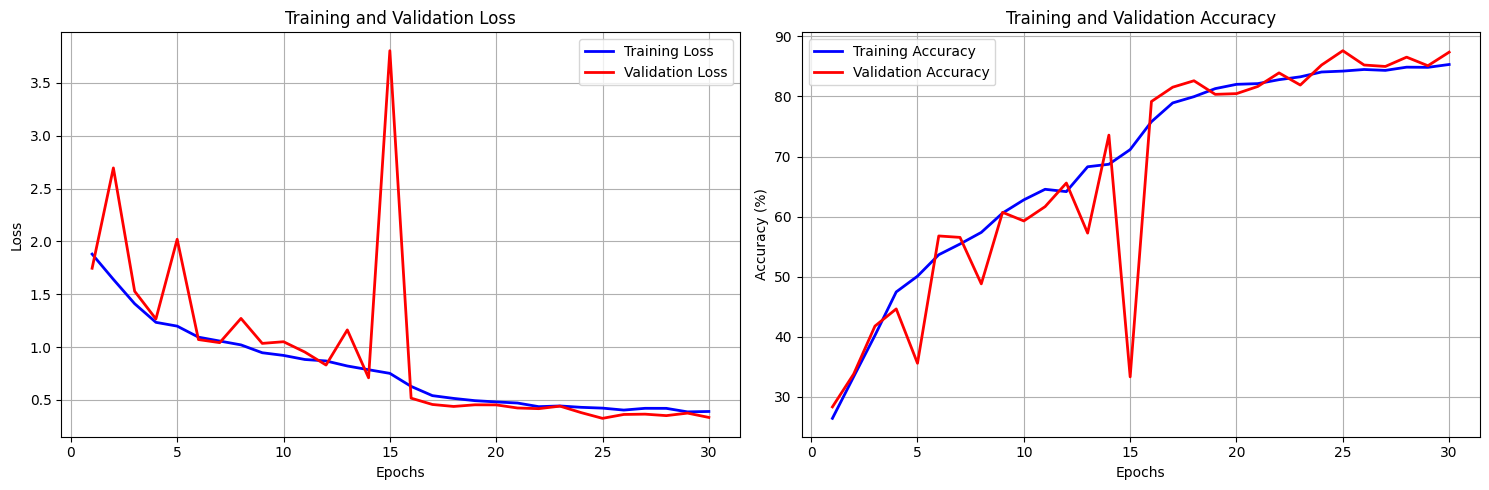

In [11]:
# Plot training curves
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

In [12]:
def calculate_per_class_accuracy(all_labels, all_predictions, class_names):
    """
    Calculate and display accuracy for each class.
    """
    print("📈 Calculating per-class accuracy...")

    cm = confusion_matrix(all_labels, all_predictions)

    per_class_accuracy = {}
    for i in range(len(class_names)):
        if cm[i, :].sum() > 0:
            accuracy = cm[i, i] / cm[i, :].sum()
            per_class_accuracy[class_names[i]] = accuracy
        else:
            per_class_accuracy[class_names[i]] = 0.0

    # Print results
    print("\n📊 Accuracy per class:")
    print("=" * 50)
    for class_name, accuracy in per_class_accuracy.items():
        print(f"  {class_name}: {accuracy:.4f} ({accuracy*100:.1f}%)")

    # Bar plot
    plt.figure(figsize=(12, 6))
    classes = list(per_class_accuracy.keys())
    accuracies = list(per_class_accuracy.values())

    bars = plt.bar(classes, accuracies, color='skyblue', alpha=0.7)
    plt.title('Per-Class Accuracy', fontsize=16, fontweight='bold')
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)

    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{acc:.3f}', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    return per_class_accuracy

Test Accuracy: 89.22%

Per-class Accuracy:
Culex landing: 94.00% (282/300)
Culex smashed: 100.00% (300/300)
aegypti landing: 80.00% (240/300)
aegypti smashed: 86.67% (260/300)
albopictus landing: 87.29% (261/299)
albopictus smashed: 87.33% (262/300)
📈 Calculating per-class accuracy...

📊 Accuracy per class:
  Culex landing: 0.9400 (94.0%)
  Culex smashed: 1.0000 (100.0%)
  aegypti landing: 0.8000 (80.0%)
  aegypti smashed: 0.8667 (86.7%)
  albopictus landing: 0.8729 (87.3%)
  albopictus smashed: 0.8733 (87.3%)


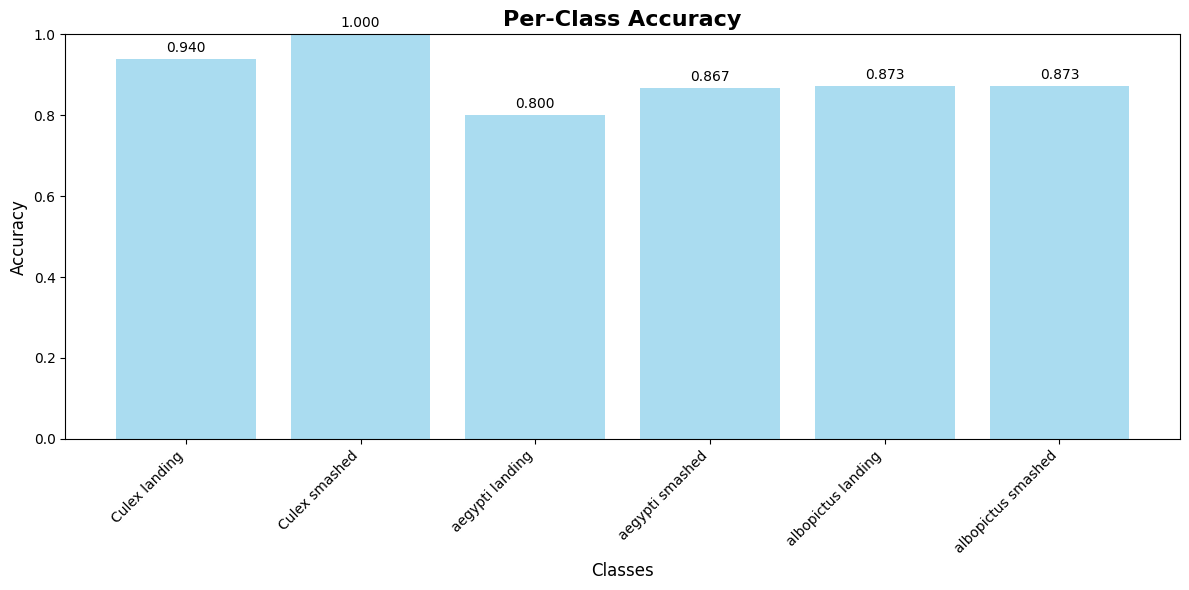

In [13]:
# Comprehensive testing function
def test_model(model, testloader, criterion, device, class_names):
    model.eval()
    correct = 0
    total = 0
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    
    all_preds = []
    all_labels = []
    correct_images = {}
    
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Per-class accuracy
            for img, label, pred in zip(images, labels, predicted):
                class_total[label.item()] += 1
                if label == pred:
                    class_correct[label.item()] += 1
                    # Store first correct prediction for each class
                    if label.item() not in correct_images:
                        correct_images[label.item()] = (img.cpu(), class_names[label.item()])
    
    # Overall accuracy
    overall_accuracy = 100 * correct / total
    print(f'Test Accuracy: {overall_accuracy:.2f}%')
    print()
    
    # Per-class accuracy
    print('Per-class Accuracy:')
    for i in range(len(class_names)):
        if class_total[i] > 0:
            class_acc = 100 * class_correct[i] / class_total[i]
            print(f'{class_names[i]}: {class_acc:.2f}% ({class_correct[i]}/{class_total[i]})')
        else:
            print(f'{class_names[i]}: No samples')
    
    return correct_images, all_labels, all_preds, overall_accuracy

# Test the model
correct_images, all_labels, all_preds, test_accuracy = test_model(model, testloader, criterion, device, class_names)

per_class_accuracy = calculate_per_class_accuracy(all_labels, all_preds, class_names)

\n============================================================
RESNET-50 RESULTS


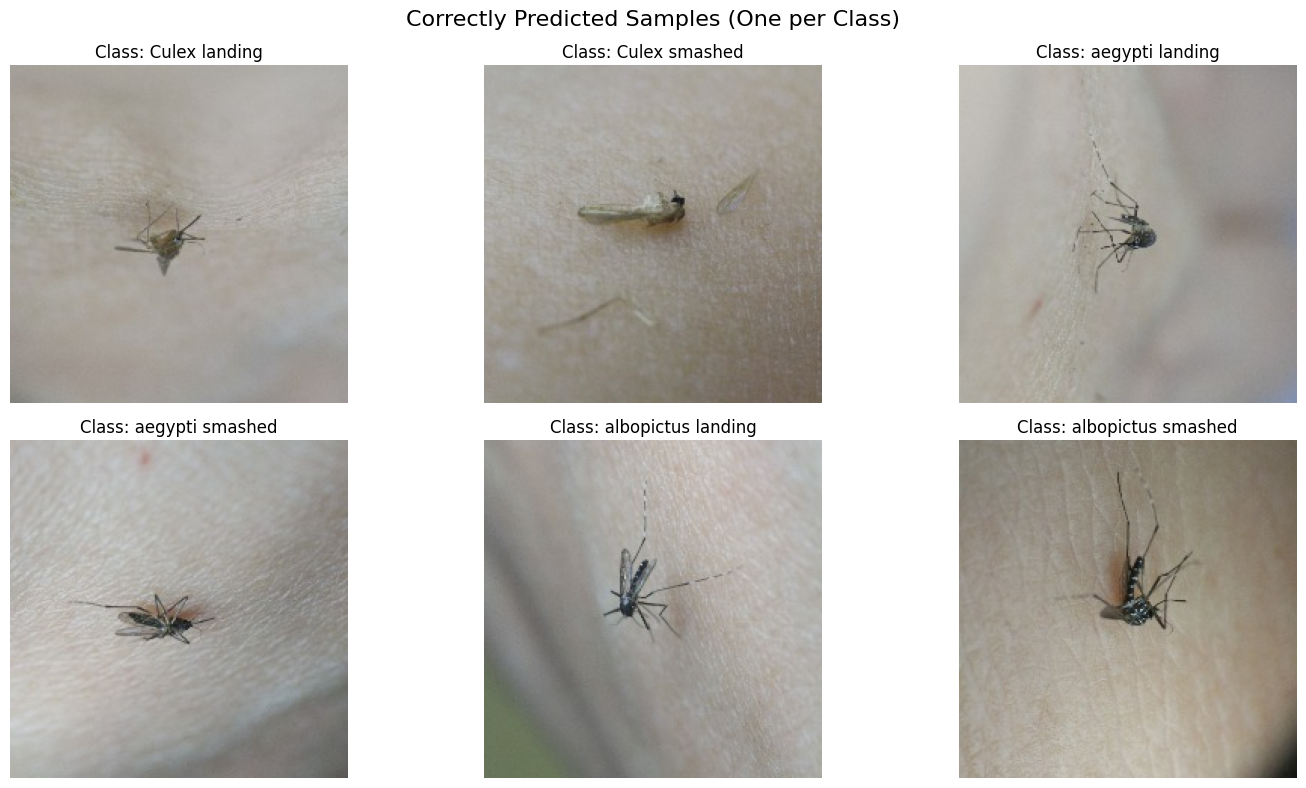

In [14]:
# Visualization functions
def plot_correct_predictions(correct_images, class_names):
    """Plot correctly predicted images for each class"""
    plt.figure(figsize=(15, 8))
    
    for i, (label_idx, (img, label_name)) in enumerate(correct_images.items()):
        plt.subplot(2, 3, i + 1)
        
        # Denormalize the image for display
        img_denorm = img.clone()
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        for t, m, s in zip(img_denorm, mean, std):
            t.mul_(s).add_(m)
        img_denorm = torch.clamp(img_denorm, 0, 1)
        
        # Convert to numpy and transpose for matplotlib
        img_np = img_denorm.permute(1, 2, 0).numpy()
        
        plt.imshow(img_np)
        plt.title(f'Class: {label_name}', fontsize=12)
        plt.axis('off')
    
    plt.suptitle('Correctly Predicted Samples (One per Class)', fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_labels, all_preds, class_names):
    """Plot confusion matrix"""
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    plt.figure(figsize=(10, 8))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix - ResNet-50", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Display results
print("\\n" + "="*60)
print("RESNET-50 RESULTS")
print("="*60)

plot_correct_predictions(correct_images, class_names)

<Figure size 1000x800 with 0 Axes>

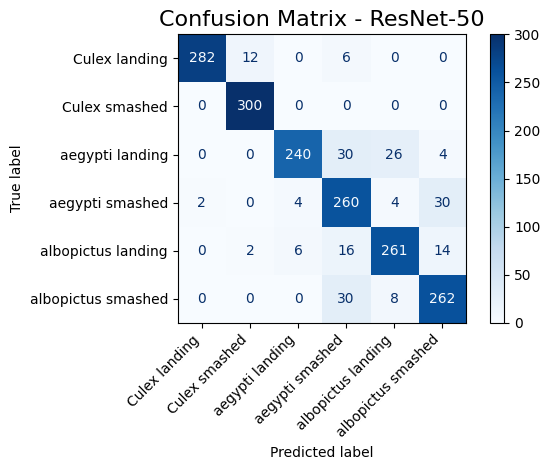

\n============================================================
MODEL SUMMARY AND COMPARISON
ResNet-50 Test Accuracy: 89.22%
Number of parameters: 23,520,326
Model size: 89.7 MB
\nKey Features of ResNet-50:
- 50 layers deep with residual connections
- Batch normalization and skip connections
- Pre-trained ImageNet weights could be used for transfer learning
- Input size: 224x224 (higher resolution than simple CNN)
- Advanced data augmentation and learning rate scheduling
\nFinal model saved as 'final_resnet50_mosquito.pth'


In [15]:
# Display confusion matrix
plot_confusion_matrix(all_labels, all_preds, class_names)

# Model summary and comparison
print("\\n" + "="*60)
print("MODEL SUMMARY AND COMPARISON")
print("="*60)
print(f"ResNet-50 Test Accuracy: {test_accuracy:.2f}%")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * 4 for p in model.parameters()) / (1024**2):.1f} MB")
print("\\nKey Features of ResNet-50:")
print("- 50 layers deep with residual connections")
print("- Batch normalization and skip connections")
print("- Pre-trained ImageNet weights could be used for transfer learning")
print("- Input size: 224x224 (higher resolution than simple CNN)")
print("- Advanced data augmentation and learning rate scheduling")

# Save the final model
torch.save(model.state_dict(), 'final_resnet50_mosquito.pth')
print("\\nFinal model saved as 'final_resnet50_mosquito.pth'")